## Complexer Poisson Example
In this example a poisson equation, with local forces on a complex domain will be solved.
The equation is:
\begin{align*}
    - D \Delta u &= g(x, F), \text{ for } x \in \Omega \\
    u &= 0 , \text{ for } x \in \partial\Omega
\end{align*}
Where $g(x, F)$ will be zero, except on a small part on the domain.

The parameter $D \in [D_{low}, D_{up}]$ and the forces $F \in [F_{low}, F_{up}]$ will be used as input parameters for the model.

In [1]:
import torchphysics as tp
import numpy as np
import torch

# set GPU:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

First the basic parameters for the problem:

In [2]:
w, h = 1., 1. # 'Size' of the domain
D_low, D_up = 0.1, 1.  # interval boundary for D
F_low, F_up = 1., 5.    # lower and upper bound for maximal force

Next we define the spaces:

In [3]:
X = tp.spaces.R2('x')
D = tp.spaces.R1('D')
F = tp.spaces.R1('F')

U = tp.spaces.R1('u') # output

Next is the domain, where we use a rectangle with some parts cut out. There we can just use '-' to create the desired domain.

In [4]:
R1 = tp.domains.Parallelogram(X, origin=[0., 0.], corner_1=[w, 0], corner_2=[0, h]) 
R2 = tp.domains.Parallelogram(X, origin=[0.7, 0], corner_1=[1.1, 0.0], corner_2=[0.7, 0.4])
R3 = tp.domains.Parallelogram(X, origin=[0, 0.4], corner_1=[0.4, 0.4], corner_2=[0.0, 0.5])

space_domain = R1 - R2- R3

# intervals for the other inputs:
interval_D = tp.domains.Interval(D, D_low, D_up)
interval_F = tp.domains.Interval(F, F_low, F_up)

Next up we define our neural network. The input have to be values from the product space of X, D and F. 

In [5]:
model = tp.models.FCN(input_space=X*D*F, output_space=U, hidden=(50,50,50,50,50))

First we create the Dirichlet-Condition. Since the solution at the boundary should be 0, we have as an resiudal the expression: $\| u - 0 \|$, so our residual function has to return u - 0. But logically, we dont have to substract the zero. The points for now will be grid points around the boundary.

In [6]:
dirich_sampler = tp.samplers.GridSampler(space_domain.boundary, density=30) * \
                 (tp.samplers.GridSampler(domain=interval_D, n_points=8) * \
                  tp.samplers.GridSampler(domain=interval_F, n_points=8))
# since we use a grid sampler, in every iteration the same number of points will be used.
# To only create the grid once and not compute the grid points new, in each step, we make the sampler static:
dirich_sampler = dirich_sampler.make_static()

def dirich_residual(u):
    return u 

dirich_cond = tp.conditions.PINNCondition(module=model, sampler=dirich_sampler,
                                              residual_fn=dirich_residual)

Next up is the differential equation itself. There we want that the right hand side is zero, except on one small rectangle. Therefore we split this up in two different conditions. One where we want that $\Delta u=0$ and the other one for $-D\Delta u= g$. 

We start with the second one. A define a new small rectangle, where the condition should be fulfilled:

In [7]:
small_Rect = tp.domains.Parallelogram(X, origin=[0.6, 0.6], corner_1=[0.8, 0.6], corner_2=[0.6, 0.8])

pde_sampler_1 = tp.samplers.GridSampler(domain=small_Rect, n_points=400) * \
                (tp.samplers.GridSampler(domain=interval_D, n_points=8) * \
                 tp.samplers.GridSampler(domain=interval_F, n_points=8))

# again make the sampler static
pde_sampler_1 = pde_sampler_1.make_static()

# the function g will be defined as a additional data function
center = (0.7,0.7)
size = 0.1 
k = np.pi/(2*size)

def g(x, F):
    out = F * torch.cos(k*(x[:, :1]-center[0])) * torch.cos(k*(x[:, 1:]-center[1])) 
    return out

# now define the pde condition, remeber that we have bring the rhs to the left side:
def pde_residual_1(u, D, x, F):
    return - D * tp.utils.laplacian(u, x) - g(x, F)

pde_cond_1 = tp.conditions.PINNCondition(module=model, sampler=pde_sampler_1, 
                                             residual_fn=pde_residual_1,
                                             data_functions={'g': g})

On the rest of the domain, we want that $\Delta u = 0$. So we will create points in the whole domain and filter out the points that lay in the rectangle defined above. 

In [8]:
def filter_fn(x):
    # the x input will be a tensor -> cast to Point to check inside
    inside_rect = small_Rect._contains(tp.spaces.Points(x, X))
    return torch.logical_not(inside_rect)

pde_sampler_2 = tp.samplers.GridSampler(domain=space_domain, density=900, filter_fn=filter_fn) * \
                (tp.samplers.GridSampler(domain=interval_D, n_points=8) * \
                 tp.samplers.GridSampler(domain=interval_F, n_points=8))

pde_sampler_2 = pde_sampler_2.make_static()

# now define the pde condition:
def pde_residual_2(D, u, x):
    return -D * tp.utils.laplacian(u, x)

pde_cond_2 = tp.conditions.PINNCondition(module=model, sampler=pde_sampler_2, 
                                             residual_fn=pde_residual_2)

Now we can check that the points are distributed correctly, by showing a scatter plot. 
Right now the boundary points are blue, the inner rectangle orange and where we have the condition $\Delta u = 0$ the points are green:

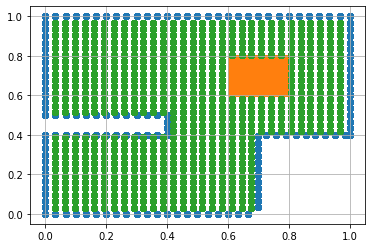

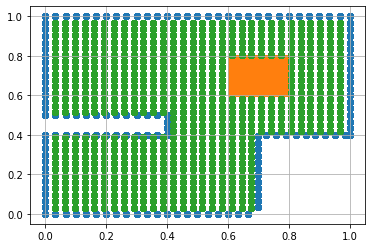

In [9]:
tp.utils.scatter(X, dirich_sampler, pde_sampler_1, pde_sampler_2)

Now we can start the training:

In [10]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0001)

solver = tp.solver.Solver([dirich_cond, pde_cond_1, pde_cond_2], optimizer_setting=optim)

import pytorch_lightning as pl

trainer = pl.Trainer(gpus=1,
                     max_steps=5000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.5 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Plot the solution:

D, F in range


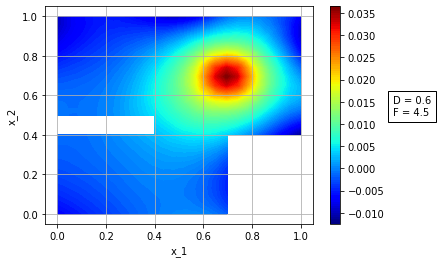

In [ ]:
plot_D = 0.6
plot_F = 4.5

if D_low < plot_D < D_up and F_low < plot_F< F_up:
    print('D, F in range')

plot_sampler = tp.samplers.PlotSampler(plot_domain=space_domain, density=500, device='cuda',
                                       data_for_other_variables={'D': plot_D, 'F': plot_F})
fig = tp.utils.plot(model, lambda u : u, plot_sampler, plot_type='contour_surface')

To compute the maximum and minimum value of the model over the domain, we can call: tp.utils.compute_min_and_max(...).
The points where the model should be evaluated can be specified with the given PointSampler. Here we just use the sampler of the plot: 

In [ ]:
from torchphysics.utils import compute_min_and_max

min_value, max_value = compute_min_and_max(model=model, sampler=plot_sampler)

-- Start evaluation of minimum and maximum --
Time to evaluate model: 0.0469205379486084
Time to evaluate User-Function: 1.2874603271484375e-05
Found the values
Min: tensor(-0.0120, grad_fn=<MinBackward1>)
Max: tensor(0.0365, grad_fn=<MaxBackward1>)
